## Clustering aglomerativo

Se refiere a una colección de algoritmos de clustering que se basan en los mismos principios: el algoritmo comienza declarando cada punto como su propio clúster y luego fusiona los dos clusters más similares hasta que se satisfaga algún criterio de detención. El criterio de detención implementado en scikit-learn es el número de clústeres, por lo que los clústeres similares se fusionan hasta que solo se deja el número especificado de clústeres. Existen varios criterios de vinculación que especifican cómo se mide exactamente el "grupo más similar". Esta medida siempre se define entre dos clusters existentes.

Las siguientes tres opciones se implementan en scikit-learn:

* `ward`, la opción predeterminada, `ward` selecciona los dos clusters para fusionarlos de modo que la varianza dentro de todos los clusters aumente menos. Esto a menudo conduce a clustering que tienen un tamaño relativamente igual.

* `average` combina los dos grupos que tienen la distancia promedio más pequeña entre todos sus puntos.

* `complete`, el enlace `complete` (también conocido como enlace máximo) fusiona los dos grupos que tienen la distancia máxima más pequeña entre sus puntos.

`ward` funciona en la mayoría de los conjuntos de datos. Si los grupos tienen un número muy diferente de miembros (si uno es mucho más grande que todos los demás, por ejemplo), `average` o `complete` podría funcionar mejor.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity


def dibuja_algoritmo_aglomerativo():
    # generamos datos artificiales dos dimensionales
    X, y = make_blobs(random_state=0, n_samples=12)
    agg = AgglomerativeClustering(n_clusters=X.shape[0], compute_full_tree=True).fit(X)
    fig, axes = plt.subplots(X.shape[0] // 5, 5, subplot_kw={'xticks': (),
                                                             'yticks': ()},
                             figsize=(20, 8))

    eps = X.std() / 2

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    puntos_grid = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    for i, ax in enumerate(axes.ravel()):
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)
        ax.set_title("Paso %d" % i)
        ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                puntos = X[agg.labels_ == cluster]
                otros_puntos = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(puntos)
                puntuacion = kde.score_samples(puntos_grid)
                puntuacion_1 = np.min(kde.score_samples(puntos))
                puntuacion_2 = np.max(kde.score_samples(otros_puntos))
                niveles = .8 * puntuacion_1 + .2 * puntuacion_2
                ax.contour(xx, yy, puntuacion.reshape(100, 100), levels=[niveles],
                           colors='k', linestyles='solid', linewidths=2)

    axes[0, 0].set_title("Inicializacion")


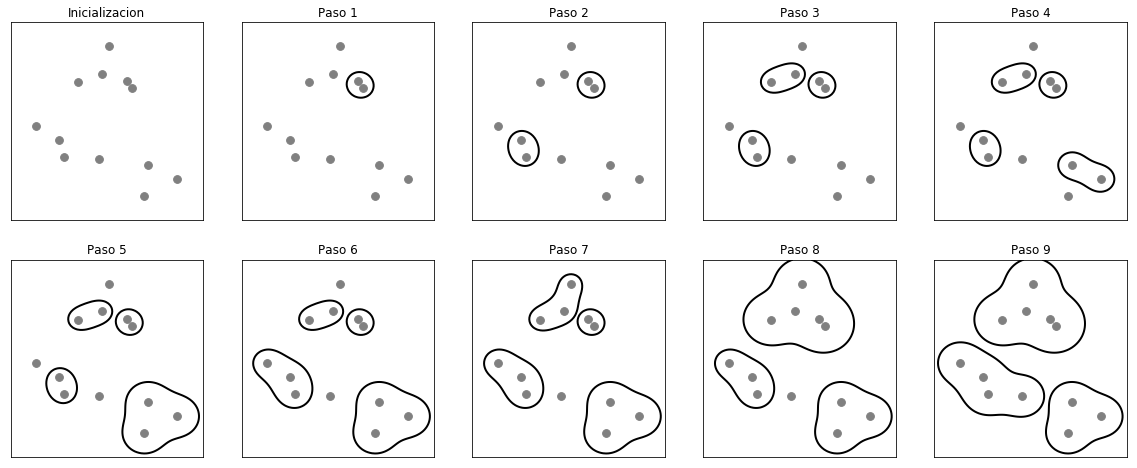

In [5]:
dibuja_algoritmo_aglomerativo()

Inicialmente, cada punto es su propio clúster. Luego, en cada paso, se fusionan los dos grupos más cercanos. En los primeros cuatro pasos, se seleccionan dos clústeres de un solo punto y estos se unen en clústeres de dos puntos. En el paso 5, uno de los clusters de dos puntos se extiende a un tercer punto  y así sucesivamente. En el paso 9, solo quedan tres clústeres. Como especificamos que estamos buscando tres clusters, el algoritmo se detiene.

Echemos un vistazo a cómo funciona el clustering  aglomerativa en los tres datos simples de clúster que utilizamos aquí. Debido a la forma en que funciona el algoritmo, el clustering  aglomerativa no puede hacer predicciones para nuevos puntos de datos.

Por lo tanto, `AgglomerativoClustering` no tiene el  método `predict`. Para construir el modelo y obtener los elementos  del clúster en el conjunto de entrenamiento, se usa el método `fit_predict`.


In [6]:
import matplotlib as mpl
from matplotlib.colors import  colorConverter

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Text(0,0.5,'Caracteristica 1')

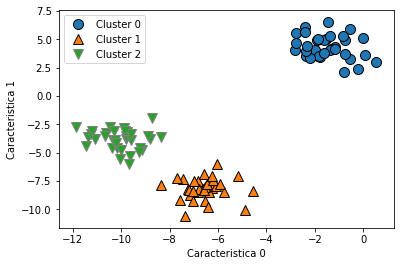

In [8]:
from sklearn.cluster import AgglomerativeClustering
X, y = make_blobs(random_state=1)
agg = AgglomerativeClustering(n_clusters=3)
asignamiento = agg.fit_predict(X)
dibuja_dispersion_discreta(X[:, 0], X[:, 1], asignamiento)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Como se esperaba, el algoritmo recupera la agrupación perfectamente. Si bien la implementación scikit-learn de aglomeración de clústeres requiere que se  especifique la cantidad de clústeres que desea que encuentre el algoritmo, los métodos de aglomeración de clústeres proporcionan cierta ayuda para elegir el número correcto, que veremos a continuación.

### Clustering jerárquico y dendrograma

El clustering aglomerativo produce lo que se conoce como un clustering  jerárquico. El clustering continúa de manera iterativa y cada punto hace  un viaje desde  un único  cluster de un punto, para pertenecer a algún cluster final. Cada paso intermedio proporciona un clustering de los datos (con un número diferente de clústeres).

A veces es útil observar todos los clustering  posibles de forma conjunta. El siguiente ejemplo muestra una superposición de todos los clustering  posibles que proporcionan una idea de cómo cada cluster se divide en cluster más pequeños:

In [14]:
# Asignación de cluster jerarquico (mostrado como lineas) generado con clustering aglomerativo, con puntos de datos numerados
def dibuja_cluster_aglomerativo():
    X, y = make_blobs(random_state=0, n_samples=12)
    agg = AgglomerativeClustering(n_clusters=3)

    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    puntos_grid = np.c_[xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)]

    ax = plt.gca()
    for i, x in enumerate(X):
        ax.text(x[0] + .1, x[1], "%d" % i, horizontalalignment='left', verticalalignment='center')

    ax.scatter(X[:, 0], X[:, 1], s=60, c='grey')
    ax.set_xticks(())
    ax.set_yticks(())

    for i in range(11):
        agg.n_clusters = X.shape[0] - i
        agg.fit(X)

        bins = np.bincount(agg.labels_)
        for cluster in range(agg.n_clusters):
            if bins[cluster] > 1:
                puntos = X[agg.labels_ == cluster]
                otros_puntos = X[agg.labels_ != cluster]

                kde = KernelDensity(bandwidth=.5).fit(puntos)
                puntuaciones = kde.score_samples(puntos_grid)
                puntuaciones1 = np.min(kde.score_samples(puntos))
                puntuaciones2 = np.max(kde.score_samples(otros_puntos))
                niveles = .8 * puntuaciones1 + .2 * puntuaciones2
                ax.contour(xx, yy, puntuaciones.reshape(100, 100), levels=[niveles],
                           colors='k', linestyles='solid', linewidths=1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

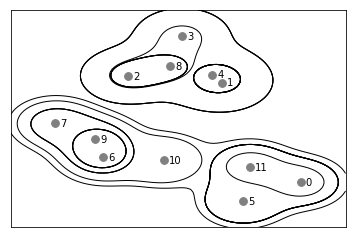

In [15]:
dibuja_cluster_aglomerativo()

Si bien esta visualización proporciona una vista muy detallada del clustering  jerárquica, se basa en la naturaleza bidimensional de los datos y por lo tanto, no se puede usar en conjuntos de datos que tienen más de dos características. Sin embargo, existe otra herramienta para visualizar el clustering  jerárquica, llamada dendrograma, que puede manejar conjuntos de datos multidimensionales.

Los algoritmos de clustering SciPy tienen una interfaz ligeramente diferente a los algoritmos de clustering scikit-learn y que sirven para dibujar dendrogramas. SciPy proporciona una función que toma una matriz de datos X y calcula una matriz de enlaces, que codifica similitudes de clústeres jerárquicos. A continuación, podemos alimentar esta matriz  de enlaces en la función de `dendrograma` de scipy para dibujar el dendrograma.

Text(0,0.5,'Distancia de clusters')

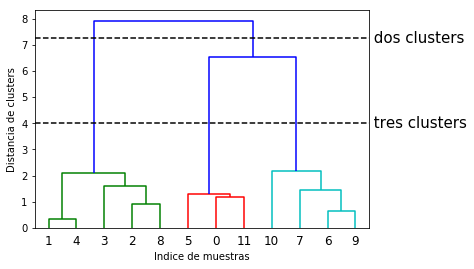

In [16]:
# Importamos la funcion  dendrogram  y la funcion ward desde SciPy
from scipy.cluster.hierarchy import dendrogram, ward


X, y = make_blobs(random_state=0, n_samples=12)
# Aplique el clustering  ward a la matriz de datos X. 
matriz_enlace = ward(X)

# Graficamos el dendrograma para la matriz enlace que contiene las distancias entre clusters
dendrogram(matriz_enlace)

# Marca los cortes en el árbol que significan dos o tres grupos

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')
ax.text(bounds[1], 7.25, ' dos clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' tres clusters', va='center', fontdict={'size': 15})
plt.xlabel("Indice de muestras")
plt.ylabel("Distancia de clusters")


El dendrograma muestra los puntos de datos como puntos en la parte inferior (numerados del 0 al 11). Luego, un árbol se dibuja con estos puntos (que representan clusters de un solo punto) como las hojas  y se agrega un nuevo nodo padre para cada dos clústeres que se unen.

El eje `y` en el dendrograma no solo especifica cuándo en el algoritmo de aglomeración se fusionan dos cluster. La longitud de cada rama también muestra qué tan separados están los clústeres fusionados. Las ramas más largas en este dendrograma son las tres líneas que están marcadas por la línea punteada llamada "tres grupos". Que estas son las ramas más largas indican que pasar de tres a dos grupos significa unir algunos puntos muy distantes. Vemos esto de nuevo en la parte superior del gráfico, donde la fusión de los dos clústeres restantes en un único clúster une una distancia relativamente grande.

Desafortunadamente, la agrupación aglomerativa aún falla al separar formas complejas como el conjunto de datos `two_moons`. Pero lo mismo no es cierto para el siguiente algoritmo DBSCAN.


## DBSCAN

Otro algoritmo clustering muy útil es DBSCAN (que significa "density based spatial clustering of applications with noise"). Los principales beneficios de DBSCAN es que no requiere que el usuario establezca el número de clústeres a priori, este algoritmo puede capturar clusters de formas complejas y puede identificar puntos que no forman parte de ningún clúster. DBSCAN es algo más lento que el clustering aglomerativa y k-means, pero sigue escalando a conjuntos de datos relativamente grandes.

DBSCAN funciona identificando puntos que se encuentran en regiones "atestadas" del espacio de características, donde muchos puntos de datos están muy juntos. Estas regiones se denominan regiones densas en el espacio de características. La idea detrás de DBSCAN es que los clusters forman regiones densas de datos, separadas por regiones que están relativamente vacías.

Los puntos que se encuentran dentro de una región densa se denominan `core samples` (o puntos centrales) y se definen de la siguiente manera. Hay dos parámetros en DBSCAN: `min_samples` y `eps`. Si hay al menos `min_samples`, muchos puntos de datos dentro de una distancia de `eps` a un punto de datos dado, ese punto de datos se clasifica como `core sample`. Las core sample que están más cerca unos de otros que la distancia `eps` se ponen en el mismo clúster por DBSCAN.

El algoritmo funciona seleccionando un punto arbitrario para comenzar. A continuación, encuentra todos los puntos con distancia `eps` o menos desde ese punto. Si hay menos que `min_sample` puntos  dentro de la distancia `eps` del punto inicial, este punto se etiqueta como `noise`, lo que significa que no pertenece a ningún clúster. Si hay más de `min_samples` puntos dentro de una distancia de `eps`, el punto se etiqueta como un core sample y se le asigna una nueva etiqueta de cluster.

Luego, se visitan todos los vecinos (dentro de los `eps`) del punto. Si aún no se les ha asignado un clúster, se les asigna la nueva etiqueta del clúster que acaba de crearse. Si son core sample, sus vecinos son visitados sucesivamente. El clúster crece hasta que no haya más core sample dentro de las distancia `eps` del clúster. Luego, se selecciona otro punto que aún no se ha visitado y se repite el mismo procedimiento.

Al final, hay tres tipos de puntos: puntos centrales, puntos que están dentro de la distancia `eps` de los puntos centrales (llamados puntos frontera) y ruido. Cuando el algoritmo DBSCAN se ejecuta en un conjunto de datos particular varias veces, el clustering de los puntos centrales es siempre la misma  y los mismos puntos siempre se etiquetarán como ruido. 

Sin embargo, un punto frontera podría ser vecino de los core samples de más de un cluster. Por lo tanto, la pertenencia a un clúster de puntos frontera  depende del orden en que se visitan los puntos. Por lo general, solo hay unos pocos puntos frontera y esta ligera dependencia del orden de los puntos no es importante. DBSCAN no permite predicciones sobre nuevos datos de prueba, por lo que utilizaremos el método `fit_predict` para realizar clustering y devolver las etiquetas del clúster en un solo paso.



In [17]:
from sklearn.cluster import DBSCAN
X, y = make_blobs(random_state=0, n_samples=12)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Miembros de los clustering:\n{}".format(clusters))

Miembros de los clustering:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Todos los puntos de datos se les asignó la etiqueta `-1`, que significa ruido. Esto es una consecuencia de los ajustes de parámetros predeterminados para `eps` y `min_samples`, que no están ajustados para conjuntos de datos pequeños. Las asignaciones de clúster para diferentes valores de `min_samples` y `eps` se muestran a continuación y se visualizan:

In [26]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])


def dibuja_dbscan():
    X, y = make_blobs(random_state=0, n_samples=12)

    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(X)
    clusters

    fig, axes = plt.subplots(3, 4, figsize=(11, 8),
                             subplot_kw={'xticks': (), 'yticks': ()})
    
    # dibujamos  los clústeres como rojo, verde y azul, y los valores atípicos (-1) con blanco

    colores = [cm3(1), cm3(0), cm3(2)]
    marcadores = ['o', '^', 'v']

    # iterar sobre la configuración de min_samples y eps
    for i, min_samples in enumerate([2, 3, 5]):
        for j, eps in enumerate([1, 1.5, 2, 3]):
            # instanciado  DBSCAN con una configuracion particular
            dbscan = DBSCAN(min_samples=min_samples, eps=eps)
            # obtenemos asignacion de cluster
            clusters = dbscan.fit_predict(X)
            print("min_samples: %d eps: %f  cluster: %s"
                  % (min_samples, eps, clusters))
            if np.any(clusters == -1):
                c = ['w'] + colores
                m = ['o'] + marcadores
            else:
                c = colores
                m = marcadores
            dibuja_dispersion_discreta(X[:, 0], X[:, 1], clusters, ax=axes[i, j], c=c,
                             s=8, marcadores=m)
            inds = dbscan.core_sample_indices_
            # vizualizamos los  core samples y clusters.
            if len(inds):
                dibuja_dispersion_discreta(X[inds, 0], X[inds, 1], clusters[inds], ax=axes[i, j], s=15, c=colores,
                                 marcadores=marcadores)
            axes[i, j].set_title("min_samples: %d eps: %.1f"
                                 % (min_samples, eps))
    fig.tight_layout()

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


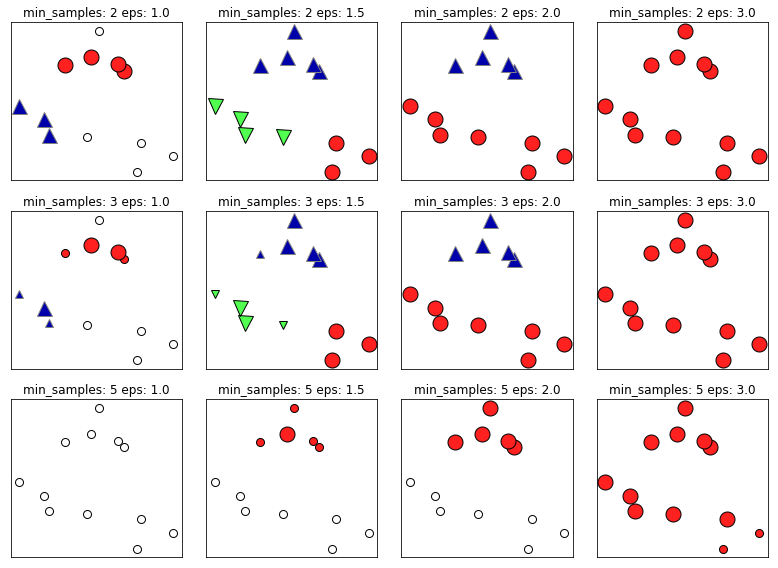

In [21]:
dibuja_dbscan()

En esta gráfico, los puntos que pertenecen a los clusters son sólidos, mientras que los puntos de ruido se muestran en blanco. Los core samples se muestran como marcadores grandes, mientras que los puntos del frontera se muestran como marcadores más pequeños. El aumento de `eps` (ir de izquierda a derecha en la figura) significa que se incluirán más puntos en un clúster. Esto hace que los clústeres crezcan, pero también puede llevar a que múltiples clústeres se unan en uno. Aumentar `min_samples` (ir de arriba a abajo en la figura) significa que menos puntos serán puntos centrales y más puntos se etiquetarán como ruido.

El parámetro `eps` es algo más importante ya que determina qué significa que los puntos estén "cerca". Colocar `eps` a ser muy pequeño significará que ningún punto es un core sample  y puede llevar a que todos los puntos se etiqueten como ruido. Establecer `eps` para que sea muy grande dará como resultado que todos los puntos formen un único cluster.

La configuración `min_samples` determina principalmente si los puntos en regiones menos densas se etiquetarán como valores atípicos o como sus propios clústeres. Si decrece `min_samples`, todo lo que hubiera sido un clúster con menos `min_samples`, muchas muestras ahora se etiquetará como ruido. `min_samples` por lo tanto determina el tamaño mínimo del cluster.

Si bien DBSCAN no requiere establecer el número de clústeres explícitamente, la configuración de `eps` controla implícitamente cuántos clústeres se encontrarán. Encontrar una buena configuración para `eps` es a veces más fácil después de escalar los datos usando `StandardScaler` o `MinMaxScaler`, ya que el uso de estas técnicas de escala garantizará que todas las características tengan rangos similares.


Text(0,0.5,'Caracteristica 1')

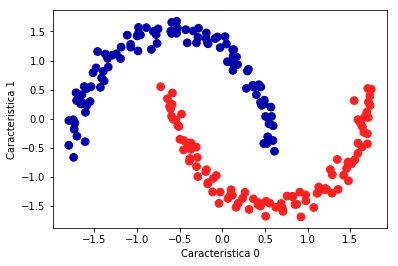

In [27]:
# Corremos DBSCAN con el conjunto de datos two_moons
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescalamos  los datos a una media cero y varianza 1 
escalador = StandardScaler()
escalador.fit(X)
X_escalado = escalador.transform(X)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_escalado)

# dibujamos el asignamiento de clusters
plt.scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters, cmap=cm2, s=60)
plt.xlabel("Caracteristica 0")
plt.ylabel("Caracteristica 1")

Como el algoritmo produjo el número deseado de clústeres (dos), la configuración de los parámetros parece funcionar bien. Si disminuimos `eps` a 0.2 (desde el valor predeterminado de 0.5), obtenemos ocho clusters, que claramente son demasiados. El aumento de eps a `0.7` da como resultado un solo clúster.

Al usar DBSCAN, se debe tener cuidado con el manejo de las asignaciones de clúster devuelto. El uso de `-1` para indicar ruido puede generar efectos inesperados al usar las etiquetas del clúster para indexar otra matriz.
